<a href="https://colab.research.google.com/github/hpink97/loan_default_predictor/blob/main/03_ml_preprocessing_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np 
import gc #free up memory
import matplotlib.pyplot as plt

import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from sklearn.impute import KNNImputer
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, f1_score, auc
from sklearn.preprocessing import RobustScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [25]:
df = pd.read_csv('CreditRisk_feature_selected.csv')
df.shape

(307511, 77)

In [26]:
na_count = df.isna().sum()
missing_data = na_count[na_count>0]
missing_data

ext_source_3                 60965
ext_source_1                173378
ext_source_2                   660
days_last_phone_change           1
floorsmax_avg               153020
floorsmax_medi              153020
floorsmax_mode              153020
amt_goods_price                278
elevators_avg               163891
elevators_medi              163891
own_car_age                 202929
livingarea_avg              154350
livingarea_medi             154350
totalarea_mode              148431
floorsmin_avg               208642
floorsmin_medi              208642
elevators_mode              163891
floorsmin_mode              208642
livingarea_mode             154350
apartments_avg              156061
apartments_medi             156061
def_30_cnt_social_circle      1021
apartments_mode             156061
def_60_cnt_social_circle      1021
dtype: int64

In [27]:
##set car age to high if they don't have a car
no_car = df.flag_own_car=='N'
old_car_age = df.own_car_age.dropna().quantile(0.95)
df.loc[no_car, 'own_car_age'] = old_car_age


In [ ]:
# Fill NA based on a kNN nearest neighours approach
numeric_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
imputer = KNNImputer(n_neighbors=4)  # Specify the number of nearest neighbors to consider
imputer.fit(df[numeric_cols])
df[numeric_cols] = imputer.transform(df[numeric_cols])



In [13]:
# Identify binary columns with only 2 unique values
y = df.target
X = df.drop(['target','sk_id_curr'],axis=1)

binary_cols = [col for col in X.columns if X[col].nunique() == 2]

label_encoders = {}

# Label encode binary columns
for col in binary_cols:
    label_encoder = LabelEncoder()
    X[col] = label_encoder.fit_transform(X[col])
    # Store the label encoder for later use
    label_encoders[col] = label_encoder




In [14]:
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
X = pd.get_dummies(X, columns=categorical_cols)
X

,ext_source_3,ext_source_1,ext_source_2,yrs_employed,age,avg_days_since_credit_update,perc_late,prop_credit_rejected,debt_to_credit_ratio,region_rating_client_w_city,...,name_housing_type_House / apartment,name_housing_type_Municipal apartment,name_housing_type_Office apartment,name_housing_type_Rented apartment,name_housing_type_With parents,fondkapremont_mode_not specified,fondkapremont_mode_org spec account,fondkapremont_mode_other,fondkapremont_mode_reg oper account,fondkapremont_mode_reg oper spec account
0,0.139376,0.083037,0.262949,1.744011,25.902806,499.8750,0.000000,0.000000,0.284122,2,...,1,0,0,0,0,0,0,0,1,0
1,0.535276,0.311267,0.622246,3.252567,45.900068,816.0000,0.000000,0.000000,0.000000,1,...,1,0,0,0,0,0,0,0,1,0
2,0.729567,0.505998,0.555912,0.616016,52.145106,532.0000,0.000000,0.000000,0.000000,2,...,1,0,0,0,0,0,0,1,0,0
3,0.535276,0.505998,0.650442,8.320329,52.032854,0.0000,0.000000,0.345343,0.000000,2,...,1,0,0,0,0,0,0,1,0,0
4,0.535276,0.505998,0.322738,8.317591,54.570842,783.0000,0.242424,0.000000,0.000000,2,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.535276,0.145570,0.681632,0.646133,25.535930,0.0000,0.000000,0.000000,0.000000,1,...,0,0,0,0,1,0,0,0,1,0
307507,0.535276,0.505998,0.115992,8.861220,56.878850,0.0000,0.166667,0.000000,0.000000,2,...,1,0,0,0,0,0,0,0,1,0
307508,0.218859,0.744026,0.535722,21.686520,40.974670,253.2500,0.071429,0.000000,0.453493,3,...,1,0,0,0,0,0,0,0,1,0
307509,0.661023,0.505998,0.514163,13.103350,32.747430,401.0000,0.000000,0.000000,0.000000,2,...,1,0,0,0,0,0,0,1,0,0


In [15]:
numeric_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]


scaler = StandardScaler()
scaler= scaler.fit(X[numeric_cols])
X[numeric_cols] = scaler.transform(X[numeric_cols])

In [16]:
# Calculate mean
scaled_data = X[numeric_cols]
mean_values = scaled_data.mean()
median_values = scaled_data.median()
std_values = scaled_data.std()
percentile_5 = scaled_data.quantile(0.25)
percentile_95 = scaled_data.quantile(0.75)
min_values = scaled_data.min()
max_values = scaled_data.max()

# Create a summary DataFrame
summary_stats = pd.DataFrame({
    'Mean': mean_values,
    'Median':median_values,
    'Standard Deviation': std_values,
    'percentile_25': percentile_5,
    'percentile_75': percentile_95,
    'Minimum': min_values,
    'Maximum': max_values
})

# Print the summary statistics
summary_stats

,Mean,Median,Standard Deviation,percentile_25,percentile_75,Minimum,Maximum
ext_source_3,-8.484617e-17,0.112063,1.000002,-0.564254,0.690651,-2.948272,2.176517
ext_source_1,1.024254e-15,0.012103,1.000002,0.012103,0.012103,-3.513017,3.288063
ext_source_2,-4.436401e-18,0.269598,1.000002,-0.636715,0.780210,-2.695574,1.783921
yrs_employed,-1.305965e-16,-0.166758,1.000002,-0.757396,0.433151,-1.189942,7.114213
age,3.955791e-16,-0.065764,1.000002,-0.830433,0.835248,-1.958761,2.106335
...,...,...,...,...,...,...,...
flag_own_car,1.280086e-17,-0.717914,1.000002,-0.717914,1.392925,-0.717914,1.392925
is_childless,-3.195595e-17,0.654079,1.000002,-1.528866,0.654079,-1.528866,0.654079
flag_document_16,-2.952402e-17,-0.100138,1.000002,-0.100138,-0.100138,-0.100138,9.986201
flag_document_13,-8.780377e-18,-0.059477,1.000002,-0.059477,-0.059477,-0.059477,16.813142


In [17]:
##make train test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, random_state=1
)

print(f"{X_train.shape[0]} training samples and {X_test.shape[0]} testing samples")
print(f"{y_train.sum()} ({y_train.mean()*100:.3f}%) positives in training set, {y_test.sum()} ({y_test.mean()*100:.3f})% positives in testing set")


230633 training samples and 76878 testing samples
18565 (8.050%) positives in training set, 6260 (8.143)% positives in testing set


In [18]:
from sklearn.ensemble import RandomForestClassifier



# Instantiate the Random Forest classifier
class_weights = {0: 12,
                 1: 1}
rf_classifier = RandomForestClassifier(n_estimators=120, random_state=42, 
                                       class_weight=class_weights)


# Train the model
rf_classifier.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf_classifier.feature_importances_


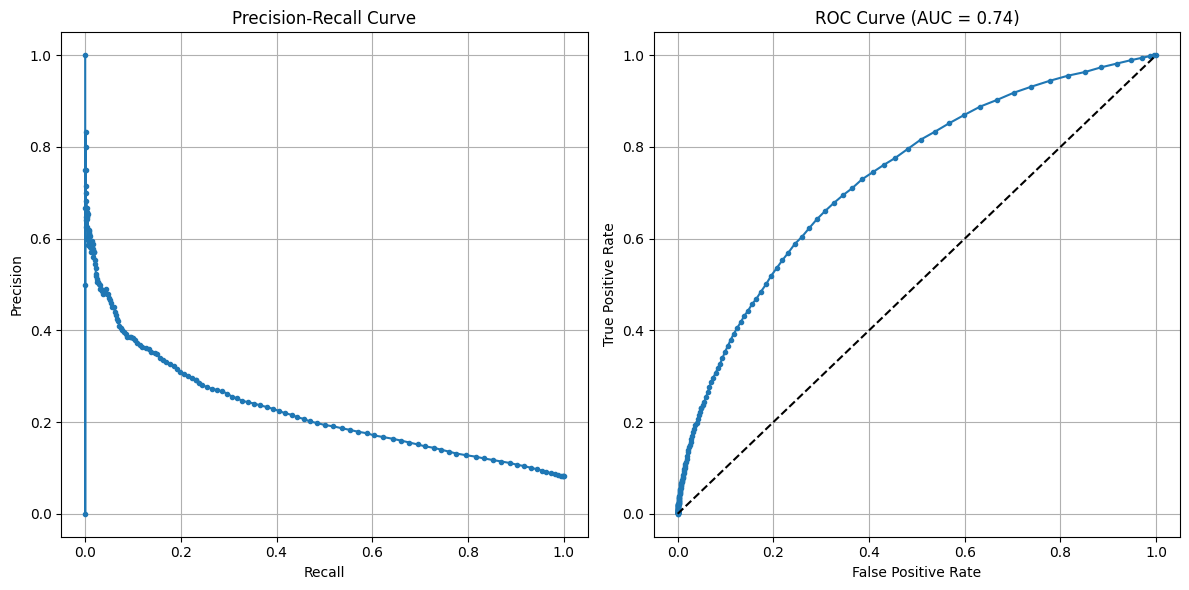

Precision: 0.0817
Recall: 0.9995
F1 Score: 0.2570
ROC-AUC: 0.7351


In [19]:
def evaluate_performance(model, X, y_true):
    """
    Evaluate model performance for binary classification and plot visualizations.

    Parameters:
        model: Trained binary classification model.
        X (array-like): Input features.
        y_true (array-like): True binary labels.
    """
    # Predict probabilities for the positive class
    y_pred_prob = model.predict_proba(X)[:, 1]

    # Compute precision, recall, and thresholds
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_prob)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_prob)
    ##calculate best threshold 
    j_stat = tpr - fpr
    index_for_best_threshold = np.argmax(j_stat)
    best_threshold = thresholds_roc[index_for_best_threshold]
    y_pred = np.where(y_pred_prob >= best_threshold, 1, 0)



    roc_auc = roc_auc_score(y_true, y_pred_prob)

    # Compute F1 score
    
    f1 = f1_score(y_true, y_pred)

    # Compute confusion matrix
    #cm = confusion_matrix(y_true, y_pred)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Precision-Recall curve
    axs[0].plot(recall, precision, marker='.')
    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_title('Precision-Recall Curve')
    axs[0].grid(True)

    # Plot ROC curve
    axs[1].plot(fpr, tpr, marker='.')
    axs[1].plot([0, 1], [0, 1], 'k--')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('ROC Curve (AUC = {:.2f})'.format(roc_auc))
    axs[1].grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print performance metrics
    #print(cm)
    print('Precision: {:.4f}'.format(precision[1]))
    print('Recall: {:.4f}'.format(recall[1]))
    print('F1 Score: {:.4f}'.format(f1))
    print('ROC-AUC: {:.4f}'.format(roc_auc))


evaluate_performance(rf_classifier, X_test, y_test)

In [ ]:
# Define the objective function for Bayesian optimization
def xgb_objective(n_estimators, gamma, scale_pos_weight,colsample_bynode,
                  learning_rate, max_depth, subsample, colsample_bytree):
    # Convert hyperparameters to appropriate types
    learning_rate = float(learning_rate)
    max_depth = int(max_depth)
    subsample = max(min(float(subsample), 1), 0)
    colsample_bytree = max(min(float(colsample_bytree), 1), 0)
    colsample_bynode = max(min(float(colsample_bytree), 1), 0)



    # Create the XGBClassifier model with the specified hyperparameters
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        gamma = gamma,
        scale_pos_weight=scale_pos_weight,
        colsample_bynode=colsample_bynode,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    # Perform cross-validation and calculate the ROC AUC score
    roc_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()

    # Return the negative ROC AUC score (Bayesian optimization minimizes the objective function)
    return -roc_auc

# Define the parameter ranges for Bayesian optimization
pbounds = {
    'n_estimators':(100, 5000),
    'gamma':(0.2, 1),
    'scale_pos_weight':(1,50),
    'colsample_bynode' : (0.3,1),
    'learning_rate': (0.001, 0.1),
    'max_depth': (3, 14),
    'subsample': (0.25, 1),
    'colsample_bytree': (0.25, 1)
}

# Perform Bayesian optimization
optimizer = BayesianOptimization(
    f=xgb_objective,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)
optimizer.maximize(init_points=10, n_iter=30)

# Get the best hyperparameters and maximum ROC AUC score
best_params = optimizer.max['params']
best_score = -optimizer.max['target']




In [22]:
# Train the final XGBClassifier model with the best hyperparameters
best_model = xgb.XGBClassifier(
    
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)
best_model.fit(X, y)

0.5